# Python Spam Email Classification [📧](https://getemoji.com/)

By Emily Goodwin 

In [1]:
#---- Import Libraries:

#Analytics
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Text Cleaning
import re #for text replacement
import nltk
from nltk.corpus import stopwords

#Word Frequency Analysis
from collections import OrderedDict
from wordcloud import WordCloud

#Text Train/Test
import random

#Naive Bayes Classification
from sklearn.naive_bayes import MultinomialNB

#Random Forest Classification
from sklearn.ensemble import RandomForestClassifier

#Stochastic Gradient Descent Classification
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

#Neural Network Classification
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

#Ensemble Classification
from sklearn.ensemble import VotingClassifier

#Classifier Performance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

#Suppress Warnings
import warnings
warnings.filterwarnings("ignore")

## Introducing the Data Set

Source: Github csv file

-   This file contains the text of over 5000 email exchanges, with each email's respective label as either spam or ham (ham means not spam)

-   Each email is labeled as either 1 or 0, indicating whether it is spam or not

-   The majority of emails are not spam

[*Link to data source*](https://github.com/Balakishan77/Spam-Email-Classifier)

**The goal:** To clean/manipulate the data such that I accurately predict spam email messages, using machine learning classification. Ideally, I can make multiple classifiers with a high performance metrics, exploring different options.


In [2]:
#Load the email data
emails = pd.read_csv('spamham.csv')
emails = emails.drop_duplicates()

emails

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1
...,...,...
5723,Subject: re : research and development charges...,0
5724,"Subject: re : receipts from visit jim , than...",0
5725,Subject: re : enron case study update wow ! a...,0
5726,"Subject: re : interest david , please , call...",0


## Spam/Ham Email Distribution

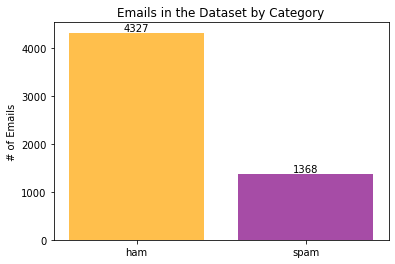

Percent of Spam: 24.02% 
Percent of Ham: 75.98%


In [3]:
amounts_df = pd.DataFrame(emails['spam'].value_counts())
amounts_df = amounts_df.rename(columns={'spam':'freq'})

label = ['ham', 'spam']
barplot = plt.bar(label, amounts_df['freq'], color=['orange','purple'], alpha=0.7)
plt.ylabel('# of Emails')
plt.title('Emails in the Dataset by Category')
plt.bar_label(barplot)
plt.show()

percent_spam = amounts_df.iloc[1,0]/(amounts_df.iloc[1,0] + amounts_df.iloc[0,0])
percent_ham = amounts_df.iloc[0,0]/(amounts_df.iloc[1,0] + amounts_df.iloc[0,0])
print(f"Percent of Spam: {round(percent_spam*100, 2)}% \nPercent of Ham: {round(percent_ham*100, 2)}%")

## Cleaning the data: 🧽

We want to remove ...

-   The introductory "Subject:"
-   all stop words, such as "a," "the," "is," "are," etc
-   special characters and punctuation
-   numbers, hyperlinks
-   extra spaces

In [4]:
def clean_emails(email):
    #Remove each "Subject: " intro
    email = re.sub(r'Subject: ', '', email)
    
    #Convert to lowercase
    email = email.lower()
    
    #Remove URLs
    email = re.sub(r'http\\s+|www\\.\\s+', "", email)
    
    #Remove numbers
    email = re.sub(r'\d+', '', email)
    
    #Remove Punctuation
    email = re.sub(r'[^\w\s]', '', email)
    
    #Remove underscores
    email = re.sub(r'_', '', email)
    
    #Remove all stop words
    stopwrds = stopwords.words('english')
    email_words = email.split()
    email_words_new = []
    for word in email_words: 
        if word not in stopwrds:
            email_words_new.append(word)
    email = " ".join(email_words_new)
    
    #Remove extra white spaces
    email = re.sub(r'\s+', ' ', email)
    
    #If there is a space at the beginning or end of the email, remove it
    email = email.strip()
    
    return(email)

cleaned_list = list(map(clean_emails, emails['text']))
emails['text_cleaned'] = cleaned_list

emails = emails.reindex(columns=['text', 'text_cleaned', 'spam'])

In [5]:
print(f"A spam email message pre-cleaning: \n\"{emails['text'][16]}\"\n")
print(f"That same email message post-cleaning: \n\"{emails['text_cleaned'][16]}\"")

A spam email message pre-cleaning: 
"Subject: only our software is guaranteed 100 % legal .  name - brand software at low , low , low , low prices  everything comes to him who hustles while he waits .  many would be cowards if they had courage enough ."

That same email message post-cleaning: 
"software guaranteed legal name brand software low low low low prices everything comes hustles waits many would cowards courage enough"


## Manipulating the Data for Common Words

-   What are the most frequent words used in both spam and ham emails?

In [6]:
#Sub data frames of 'emails'
spam_emails = emails[emails["spam"] == 1]
ham_emails = emails[emails["spam"] == 0]

#Identify the frequencies of words in emails
spam_concat = " ".join(spam_emails.text_cleaned.tolist()) #all spam emails become one string
spam_list_terms = (spam_concat).split() #split the string into a list of words
spam_unique_terms, spam_freq_terms = np.unique(spam_list_terms, return_counts = True) #identify all unique words and counts

ham_concat = " ".join(ham_emails.text_cleaned.tolist()) #all ham emails become one string
ham_list_terms = (ham_concat).split()  #split the string into a list of words
ham_unique_terms, ham_freq_terms = np.unique(ham_list_terms, return_counts = True) #identify all unique words and counts

#Construct data frames of all unique words with their respective frequencies
freq_spam = pd.DataFrame(spam_unique_terms, columns=["word"])
freq_spam["freq"] = spam_freq_terms
freq_spam = freq_spam.sort_values(by="freq", ascending=False)
print("\nSpam Email Word Frequencies:\n", freq_spam.head(), "\n")

freq_ham = pd.DataFrame(ham_unique_terms, columns=["word"])
freq_ham["freq"] = ham_freq_terms
freq_ham = freq_ham.sort_values(by="freq", ascending=False)
print("\nHam Email Word Frequencies:\n", freq_ham.head())


Spam Email Word Frequencies:
              word  freq
3005          com   998
2125     business   844
3092      company   805
5098        email   804
7888  information   740 


Ham Email Word Frequencies:
            word   freq
6883      enron  13329
6401        ect  11410
22850     vince   8468
9708        hou   5567
11239  kaminski   4723


## Spam Email Word Cloud ☁️

The output is similar to what we'd expect from spam emails

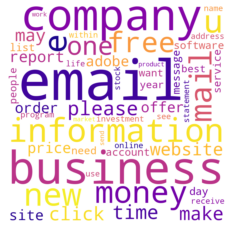

In [7]:
spam_wordcloud = WordCloud(max_words=50,
                           collocations = False, background_color = 'white',
                           colormap="plasma", height=1000, width=1000,
                           random_state=1).generate(spam_concat)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Ham Email Word Cloud

This word cloud is quite interesting. Perhaps the ham emails were communications within the business of
Enron, former energy company based in Houston, TX.

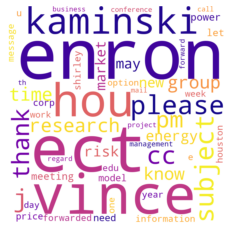

In [8]:
ham_wordcloud = WordCloud(max_words=50,
                           collocations = False, background_color = 'white',
                           colormap="plasma", height=1000, width=1000,
                           random_state=1).generate(ham_concat)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Word Frequency Distributions
- We want to learn about how often words tend to repeat in the spam and ham emails
- For example, we know that "business" comes up 844 times out of all the spam emails, but what might the word frequency distribution look like for all words?
    - Looking at the distributions, as well as identifying descriptive statistics ($\mu$, median, $\sigma$, etc.) helps us to understand the word frequency data better

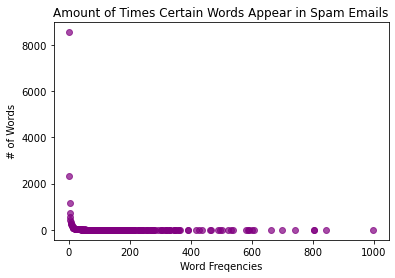

Spam Word Frequency Stats:
-------------------------
Mean: 177.01
Median: 130.5
Standard Deviation: 166.95


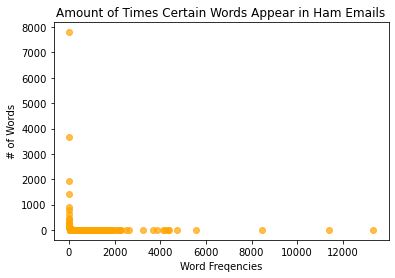

Ham Word Frequency Stats:
-------------------------
Mean: 538.22
Median: 288.5
Standard Deviation: 1019.02


In [9]:
#Spam Emails -------------
spam_freq_plot = pd.DataFrame(freq_spam['freq'].value_counts())
word_frequencies = spam_freq_plot.index.values
amount_of_words = spam_freq_plot['freq'].values

barplot = plt.scatter(word_frequencies, amount_of_words, color='purple', marker='o',alpha=0.7)
plt.ylabel('# of Words')
plt.xlabel('Word Freqencies')
plt.title('Amount of Times Certain Words Appear in Spam Emails')
plt.show()

print("Spam Word Frequency Stats:\n-------------------------")
print(f"Mean: {round(np.mean(word_frequencies), 2)}")
print(f"Median: {round(np.median(word_frequencies), 2)}")
print(f"Standard Deviation: {round(np.std(word_frequencies), 2)}")

#Ham Emails -------------
ham_freq_plot = pd.DataFrame(freq_ham['freq'].value_counts())
word_frequencies = ham_freq_plot.index.values
amount_of_words = ham_freq_plot['freq'].values

barplot = plt.scatter(word_frequencies, amount_of_words, color='orange', marker='o',alpha=0.7)
plt.ylabel('# of Words')
plt.xlabel('Word Freqencies')
plt.title('Amount of Times Certain Words Appear in Ham Emails')
plt.show()

print("Ham Word Frequency Stats:\n-------------------------")
print(f"Mean: {round(np.mean(word_frequencies), 2)}")
print(f"Median: {round(np.median(word_frequencies), 2)}")
print(f"Standard Deviation: {round(np.std(word_frequencies), 2)}")

## Further Cleaning Necessary? Maybe

After we got a chance to look at the work frequencies, we can infer a couple of things...

-   The most common words in the ham data set reveal that many of the email exchanges likely occurred at the energy corporation, Emron, based in Houston, TX, under the leadership of Vince Kaminski.
    -   In fact, out of 4327 ham email exchanges, "emron" is mentioned over 13 thousand times. That's about 3 times per email.
    -   This is pretty cool, but also it indicates that this specific data set might be too biased to train for classification of emails outside of the organization
    -   If we were making a real classifier, we might want more emails in general
-   There are also quite a few words that are spelled incorrectly (or aren't real words) in the emails. It seems that more occurrences of misspellings are in the spam emails, so identifying misspellings could be used to our advantage, although names might also be flagged.
-   To reduce noise, we could alter the email data to contain only the most frequently used words, like the top 500 for both spam and ham

We don't necessarily have to further clean this data, but it's worth considering patterns like these. Cleanup can significantly improve classifier accuracy.

In [10]:
#Shuffle all the rows in the data frame so that the order is randomized
emails = emails.sample(frac=1)
emails = emails.reset_index(drop=True)

#Remove the uncleaned column, we don't need it anymore
emails = emails[['text_cleaned', 'spam']]
emails = emails.rename(columns={"text_cleaned": "text"})

## Altering the Email Data Format for Optimized Classification

We are converting the email data to a matrix with the top most used words each set (900 for spam and 600 for ham) as columns. This can help to filter out insignificant, rarely used words which if left untouched, might make our classifier "overfit."


In [11]:
#Top words for spam and ham, combined (no repeats)

top_spam = freq_spam["word"][0:899].tolist()
top_ham = freq_ham["word"][0:599].tolist()

top_words, word_order = np.unique((top_spam + top_ham), return_counts=True) #creates a list of the top words in both sets
top_words = top_words[np.argsort(np.unique((top_spam + top_ham), return_index=True)[1])] #controls the order of output


In [12]:
#Convert the email data to a matrix with the top words as features
#this form is also known as a "bag-of-words" model

for i in range(0, emails.shape[0]):
    #for each email (row) ...
    message = emails['text'][i]
    message_words = message.split()
    email_counts = [0] * (len(top_words)) #creates a list of 0s
    for j in range(0, len(message_words)):
        #for each word in the email ...
        if message_words[j] in top_words:
            ind = np.where(top_words == message_words[j])[0][0]
            email_counts[ind] = email_counts[ind] + 1
    if i == 0:
        emails_counts_matrix = np.array([email_counts])
    else:
        emails_counts_matrix = np.concatenate((emails_counts_matrix, [email_counts]))

spam_ham_matrix = pd.DataFrame(emails_counts_matrix)
spam_ham_matrix = spam_ham_matrix.rename(columns=dict(zip(spam_ham_matrix.columns, top_words)))

spam_ham_matrix

,com,business,company,email,information,e,money,free,http,get,...,directly,scott,kim,rick,paulo,mba,status,license,feb,nd
0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,2,0,1,0,4,0,0,0,1,...,0,0,0,0,0,3,0,0,0,0
3,0,2,0,0,5,1,17,2,0,8,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5690,0,2,0,0,1,2,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5691,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5692,1,0,0,0,1,1,0,1,0,20,...,0,0,0,0,0,0,0,0,0,0
5693,0,1,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Machine Learning Classification 📊
Exploring some classifiers and see how they perform with the data

In [13]:
#Split the data into training and testing sets with their respective labels, 80% train 20% test

emails_labels = emails['spam'] #log the labels

splt = round(0.8*emails.shape[0])
data_train, data_test = spam_ham_matrix.iloc[:splt], spam_ham_matrix.iloc[splt:]
labs_train, labs_test = emails_labels[:splt], emails_labels[splt:]

## Classifier #1: Naive Bayes

Bayes' Theorem: Describes the relationship between the probability of an event based on prior knowledge or beliefs

$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$

-   The Naive Bayes classifier is based on this theorem, and assumes that features are independent of each other


In [14]:
#Create the Naive Bayes classifier, train, predict, then evaluate 

nb_clf = MultinomialNB()
nb_clf.fit(data_train, labs_train)
predictions = nb_clf.predict(data_test)

print("Classifier Accuracy Array: ")
print(cross_val_score(nb_clf, data_train, labs_train, cv=3, scoring="accuracy"))

Classifier Accuracy Array: 
[0.98025016 0.97235023 0.97957839]


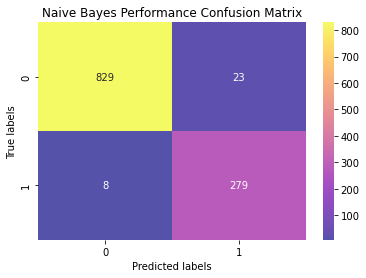

In [15]:
#Calculate Performance confusion matrix
cm = confusion_matrix(labs_test, predictions)

#Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="plasma", fmt='g', alpha=0.7)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Naive Bayes Performance Confusion Matrix')
plt.show()

#### Interpreting the Confusion Matrix:

------------------------------------------------
Predicted Lab |  True Lab   |  Interpretation
:------------:|:-----------:|:-----------------:
        1     |      1      |  True Positive
        1     |      0      |  False Positive
        0     |      0      |  True Negative
        0     |      1      |  False Negative
        
This confusion matrix summarizes the number of correct and incorrect predictions made by the Naive Bayes classifier. Ideally, there 
is a high proportion of true negative (0-0) and true positive (1-1) predictions.

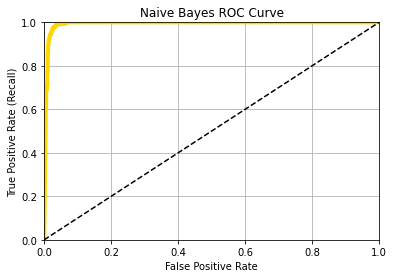

Naive Bayes Classifier ROC AUC Score: 0.9933339876658324


In [16]:
#ROC Curve with the Naive Bayes Classfier

nb_scores = nb_clf.predict_proba(data_test)[:, 1]

fpr, tpr, thresholds = roc_curve(labs_test, nb_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=4, label=label, color='gold', alpha=1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title("Naive Bayes ROC Curve")
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)
plt.show()

nb_roc_score = roc_auc_score(labs_test, nb_scores)
print('Naive Bayes Classifier ROC AUC Score:', nb_roc_score)

The closer the AUC is to 1, the better the classifier. Ideally, the ROC curve will hug the top left corner of the plot, indicating high specificity and sensitivity. A curve slope close to 1 (like the dashed line) signifies a bad classifier. We can see here that the curve hugs the top left corner pretty well.

## Classifier #2: Random Forest 🌳

Random forests: An ensmble learning algorithm 🌳🌳🌳
- Random forest classifiers build multiple decision trees on randomly selected subsets of data and features
- They then combine the outputs of these trees to make a final prediction
- The random forest method is often used for classification because of its tendency to perform with high accuracy

In [17]:
#Create the Random Forest classifier, train, predict, then evaluate 

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(data_train, labs_train)
predictions = rnd_clf.predict(data_test)

print("Random Forest Classifier Accuracy Array: ")
print(cross_val_score(rnd_clf, data_train, labs_train, cv=3, scoring="accuracy"))

Random Forest Classifier Accuracy Array: 
[0.9361422  0.92297564 0.93280632]


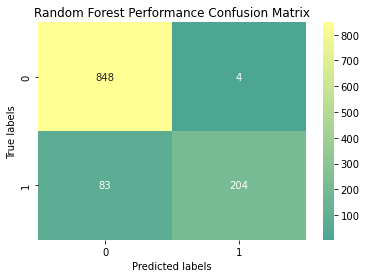

In [18]:
#Calculate Performance confusion matrix
cm = confusion_matrix(labs_test, predictions)

#Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="summer", fmt='g', alpha=0.7)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Performance Confusion Matrix')
plt.show()

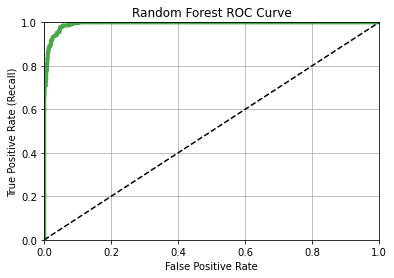

Random Forest Classifier ROC AUC Score: 0.9939801410086535


In [19]:
#ROC Curve with the Random Forest Classfier

rnd_scores = rnd_clf.predict_proba(data_test)[:, 1]

fpr, tpr, thresholds = roc_curve(labs_test, rnd_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=4, label=label, color='green', alpha=0.7)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title("Random Forest ROC Curve")
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)
plt.show()

rnd_roc_score = roc_auc_score(labs_test, rnd_scores)
print('Random Forest Classifier ROC AUC Score:', rnd_roc_score)

## Classifier #3: Stochastic Gradient Descent 📉
Sochastic Gradient Descent: Used to find the values of model parameters that minimize the cost function as much as possible
- At each iteration, the algorithm randomly selects a small batch of training samples from the dataset.
- The model parameters are then updated based on the gradient of the loss function with respect to the parameters, evaluated on the minibatch.
- The process is repeated for a fixed number of iterations or until a convergence criterion is met.

In [20]:
#Create the Stochastic Gradient Descent classifier, train, predict, then evaluate 

sgd_clf = SGDClassifier(random_state=42, loss = 'hinge')
sgd_clf.fit(data_train, labs_train)
predictions = sgd_clf.predict(data_test)

print("S. Gradient Descent Classifier Accuracy Array: ")
print(cross_val_score(sgd_clf, data_train, labs_train, cv=3, scoring="accuracy"))

S. Gradient Descent Classifier Accuracy Array: 
[0.98025016 0.97564187 0.98221344]


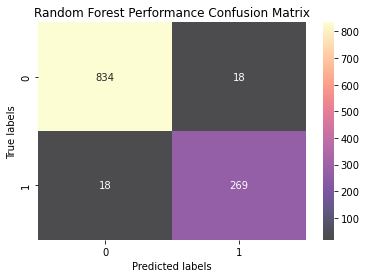

In [21]:
#Calculate Performance confusion matrix
cm = confusion_matrix(labs_test, predictions)

#Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="magma", fmt='g', alpha=0.7)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Random Forest Performance Confusion Matrix')
plt.show()

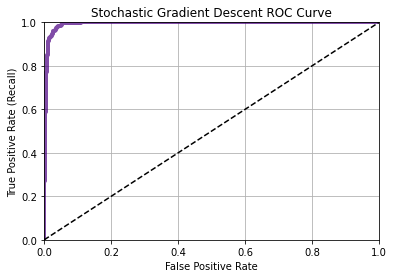

S. Gradient Descent Classifier ROC AUC Score: 0.9940742013053933


In [22]:
#ROC Curve with the S. Gradient Descent Classfier

sgd_scores = sgd_clf.decision_function(data_test)

fpr, tpr, thresholds = roc_curve(labs_test, sgd_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=4, label=label, color='indigo', alpha=0.7)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title("Stochastic Gradient Descent ROC Curve")
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)
plt.show()

sgd_roc_score = roc_auc_score(labs_test, sgd_scores)
print('S. Gradient Descent Classifier ROC AUC Score:', sgd_roc_score)

## Classifier #4: Artificial Neural Network 🧠 😅
Neural Networks: A ML technique that resembles human neurons, using interconnected, layed nodes to learn
- they are typically used in image classification

#### This neural network totally failed, unfortunately
- I actually tried to make a NN, and a CNN, but ultimately I wasn't able to figure out how to help the model to learn
    - All of the models that I created weren't able to improve accuracy with each epoch
        - Performance was stagnant
    - I even tried altering the data to make the emails a 50/50 ratio of spam to ham, and I hoped it would help
    - I'm pretty sure my neural networks just classified all emails as 'ham'
    - I suspect that the reason my neural networks were unable to learn is because there is **not enough data,** because I noticed accuracies improve as I added and removed features. I've also come to learn that neural networks need a lot of data to perform well
- The following code runs, but it doesn't achieve the desired outcome
    

In [23]:
#For the Neural Network, prepare the data for input

#Normalize data
#code normalizes the input data by dividing each value in data_train by the maximum value in the column for that word
nn_data_train = (data_train / data_train.max()).to_numpy() #convert pandas data frames to numpy arrays
nn_data_test = (data_test / data_test.max()).to_numpy()

#Set labels
nn_labs_train = labs_train.to_numpy()
nn_labs_test = labs_test.to_numpy()

In [24]:
#Create the Neural Network classifier

num_words = np.shape(nn_data_test)[1]
num_features = num_words

#Build the Neural Network layout
nn_model = Sequential()
nn_model.add(Dense(32, input_dim= nn_data_train.shape[1], activation='relu'))
nn_model.add(Dense(16, activation='relu'))
nn_model.add(Dense(1, activation='softmax')) #make the shape of the last Dense layer 1, for binary classification

#Compile the model
nn_model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate=0.001), metrics = ['accuracy'])

nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                37248     
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 37,793
Trainable params: 37,793
Non-trainable params: 0
_________________________________________________________________


In [25]:
#Train the model
history = nn_model.fit(nn_data_train, nn_labs_train, validation_data = (nn_data_test, nn_labs_test), epochs=5, batch_size=32)

#Evaluate the model
scores = nn_model.evaluate(nn_data_test, nn_labs_test)
print('Accuracy: {:.2f}%'.format(scores[1] * 100))

Epoch 1/5
143/143 [==============================] - 2s 4ms/step - loss: 0.3566 - accuracy: 0.2373 - val_loss: nan - val_accuracy: 0.7480
Epoch 2/5
143/143 [==============================] - 0s 3ms/step - loss: 0.0821 - accuracy: 0.2373 - val_loss: nan - val_accuracy: 0.7480
Epoch 3/5
143/143 [==============================] - 0s 3ms/step - loss: 0.0408 - accuracy: 0.2373 - val_loss: nan - val_accuracy: 0.7480
Epoch 4/5
143/143 [==============================] - 0s 3ms/step - loss: 0.0256 - accuracy: 0.2373 - val_loss: nan - val_accuracy: 0.7480
Epoch 5/5
36/36 [==============================] - 0s 2ms/step - loss: nan - accuracy: 0.7480
Accuracy: 74.80%


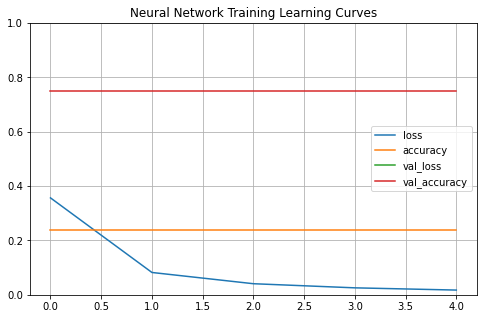

In [26]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title("Neural Network Training Learning Curves")
plt.show()

## Classifier #5: Ensemble Classifier 👯
Combines 1 or more models to create a better performing classifier overall
-  If we combine multiple models, we have the chance to boost the overall accuracy

I have chosen to combine my **naive bayes** and **random forest** models

In [27]:
#Create the Ensemble Classifier, train, predict, then evaluate

ensemble_model = VotingClassifier(estimators=[('nn', rnd_clf), ('nb', nb_clf)], voting='soft')
ensemble_model.fit(data_train, labs_train)

predictions = ensemble_model.predict(data_test)

print("Ensemble Classifier Accuracy Array: ")
print(cross_val_score(ensemble_model, data_train, labs_train, cv=3, scoring="accuracy"))

Ensemble Classifier Accuracy Array: 
[0.98222515 0.97300856 0.97826087]


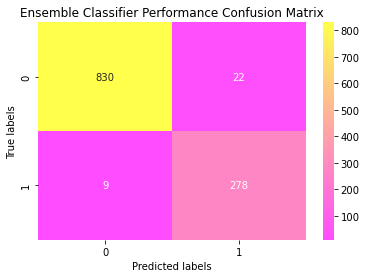

In [28]:
#Calculate Performance confusion matrix
cm = confusion_matrix(labs_test, predictions)

#Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="spring", fmt='g', alpha=0.7)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Ensemble Classifier Performance Confusion Matrix')
plt.show()

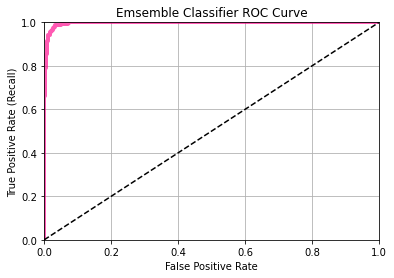

Emsemble Classifier ROC AUC Score: 0.9965892918486529


In [29]:
#ROC Curve with the Ensemble Classfier

ensemble_scores = ensemble_model.predict_proba(data_test)[:, 1]

fpr, tpr, thresholds = roc_curve(labs_test, ensemble_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=4, label=label, color='deeppink', alpha=0.7)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1]); plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.title("Emsemble Classifier ROC Curve")
    plt.grid(True)
    
plot_roc_curve(fpr, tpr)
plt.show()

ensemble_roc_score = roc_auc_score(labs_test, ensemble_scores)
print('Emsemble Classifier ROC AUC Score:', ensemble_roc_score)

## Comparing the Models
- The ensemble model performed the best, although all of the models did relatively well, excluding the neural network

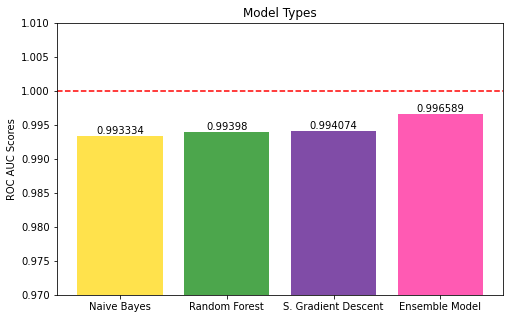

In [30]:
#Plotting the ROC Scores

roc_scores = [nb_roc_score, rnd_roc_score, sgd_roc_score, ensemble_roc_score]
model_labels = ['Naive Bayes', 'Random Forest', 'S. Gradient Descent', 'Ensemble Model']

roc_scores_df = pd.DataFrame({'roc_scores': roc_scores})
colorz = ['gold','green','indigo','deeppink']

fig = plt.figure(figsize=(8, 5))

barplot = plt.bar(model_labels, roc_scores_df['roc_scores'], color = colorz, alpha = 0.7)
plt.ylabel('ROC AUC Scores')
plt.title('Model Types')
plt.ylim(0.97, 1.01)
plt.bar_label(barplot)
plt.axhline(y=1, color='red', linestyle='--')
plt.show()



## In Conclusion...

-   The naive bayes, random forest, and stochastic gradient descent classifiers performed pretty well, including the ensemble model
-   Artificial netural networks tend to perform better with heafty amount of data
-   There are many great ways you can enhance the performance of a text classifier
    -   You need to alter how your data is presented so that you can give your classifier just the right amount of information, so that it can perform with high sensitivity and specificity
    - Presenting your text data in the 'bag-of-words' model can really help
-   Some data can have significant bias to its source, as we saw